<a href="https://colab.research.google.com/github/MadhuriMapari/MadhuriMapari/blob/main/pytorch_for_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch for Image Data 

Practice 
1. Working with images in PyTorch
2. Splitting a dataset into training, validation and test sets
3. Creating PyTorch models with custom logic by extending the nn.Module class
4. Interpreting model outputs as probabilities using softmax and picking labels
5. Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification probles
6. Setting up a training loop that also evaluates the model using the validation set 
7. Testing the model manually on randomly picked examples 
8. Saving and loading model checkpoints to avoid retraining from scratch

## Working with Image 

In [1]:
import torch 
import torchvision 
from torchvision.datasets import MNIST 

In [2]:
dataset = MNIST(root='data/',download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

The dataset has 60000 images used to train the model. there is also an additional test test of 10000 images used for evaluating models and reporting matrics in papers and reports. We cancreate the test dataset using the MNIST class by passing train= False to constructor 

In [4]:
test_dataset = MNIST(root='data/',download=False)

Lets look at sample element

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F3415434250>, 5)

Its pair, consisting of 28x28px image and a label. The image is an object of class `PIL.Image.Image`, which is a part of the Python imaging library Pillow.To view the image with Jupyter using `matplotlib` the de-facto plotting and graphing library for data science in python

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

`%matplotlib inline` indicates to jupiter that we want to plot within the notebook. without this line Jupyter will show the image in popup. 

the statements with `%` are called magic commands and are used to onfigure the behaviour of jupyter itself . 

Lets look at some of the images from the dataset.

Label:  5


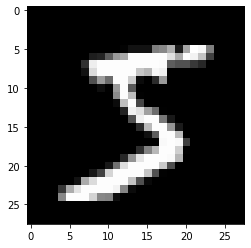

In [7]:
image,label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label: ',label)

It is evident that these images are relatively small in size, and recognoizing the digits can sometimes be challenging even for human eye. While its useful to look at these images, thses's just one problem here: 

PyTorch doesn't know how to work with images. We need to convert the images into tensors.W can do this by specifying a transformation while creating our dataset.

In [8]:
import torchvision.transforms as transforms

PyTorch datasets allow to specify one or more transform functions that are applied to theimages as they are loaded.The `torchvision.transforms` module contains many such predefined functions. Here, use the`ToTensor' transform to convert images into Pytorch tensors. 

In [9]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/',train=True,transform=transforms.ToTensor())


In [10]:
img_tensor,label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted into 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since image in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels : red, green,and blue(RGB) 

Let's look at the sample value inside the tensor

In [11]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from `0` and `1`, with `0` representing black, `1` white, and the values in between different shades of grey. 

We can also plot the tensor as an image using `plt.imshow` 

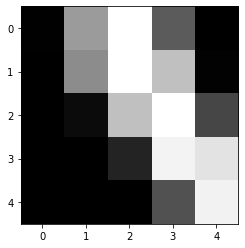

In [12]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray')

Note that we need to pass just 28x28 matrix to `plt.imshow`,without a channel dimension. We also pass a color map(cmap=gray) to indicate that we want to see a grayscale image.

### Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts: 
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - Used to evaluatethe model during training, adjust hyperparameters(learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60000 training images and 10000 test images. the test set is standardized so that different researchers can report their models results against the same collection of images. 

Since, there's no predefined validation set, we must manually split the 60000 images into training and validation datasets. Let's set aside 10000 randomly chosen images for validation. We can do this using the `random_split` method from PyTorch.


In [13]:
from torch.utils.data import random_split 

train_ds, val_ds = random_split(dataset, [50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e.,images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist pf 8s and 9s . In contrast, the training set would contain no 8s and 9s. Such a training -validation would make it impossible to train a useful model.

Because we use training data to perform Gradient decent and the validation set is only used for evaluation. they are completely separate in the label set they contain

We can now create data loader to help us load the data in batches. We'll use a batch size of 128. 

In [15]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

Set `shuffle=True` for the training dataloader to ensure that the batches generated in each epoch are different. This randomization helps generalize and speed up the training process. On the other hand, since the validation dataloader is used only for evaluating the model , there is no need to shuffle the images 